<a href="https://colab.research.google.com/github/pyt3r/springboard-package/blob/master/capstone/Feature_Engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mount Colab Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pathlib
root = pathlib.Path('/content/drive/MyDrive/home/Research/Springboard/Colab Notebooks')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Read OHLC Data

In [3]:
ohlc = pd.read_csv( root / 'ohlc.csv' )
ohlc.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,9/10/2025,111539.06,113745.24,110959.16,113538.72,113538.72,5.259328e+10
1,9/9/2025,112077.58,113225.44,110776.70,111530.55,111530.55,4.598448e+10
2,9/8/2025,111163.02,112869.23,110630.61,112071.43,112071.43,4.021281e+10
3,9/7/2025,110221.33,111591.08,110211.63,111167.62,111167.62,2.461801e+10
4,9/6/2025,110650.57,111275.02,110024.09,110224.70,110224.70,2.150072e+10


In [4]:
ohlc.shape

(366, 7)

- Date Range

In [5]:
ohlc['Date'] = pd.to_datetime( ohlc['Date'] )
ohlc.Date.min(), ohlc.Date.max()

(Timestamp('2024-09-10 00:00:00'), Timestamp('2025-09-10 00:00:00'))

- Closing Prices

In [6]:
ohlc.Close.min(), ohlc.Close.max()

(57343.17, 123344.06)

- Sort by date

In [7]:
ohlc = ohlc.sort_values( 'Date', ascending=True )
ohlc.set_index( 'Date', inplace=True )
ohlc.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-09-10,57020.10,58029.98,56419.41,57648.71,57648.71,2.885763e+10
2024-09-11,57650.29,57991.32,55567.34,57343.17,57343.17,3.704906e+10
2024-09-12,57343.17,58534.36,57330.10,58127.01,58127.01,3.383571e+10
2024-09-13,58130.32,60648.02,57650.11,60571.30,60571.30,3.249053e+10
2024-09-14,60569.12,60656.72,59517.88,60005.12,60005.12,1.642841e+10


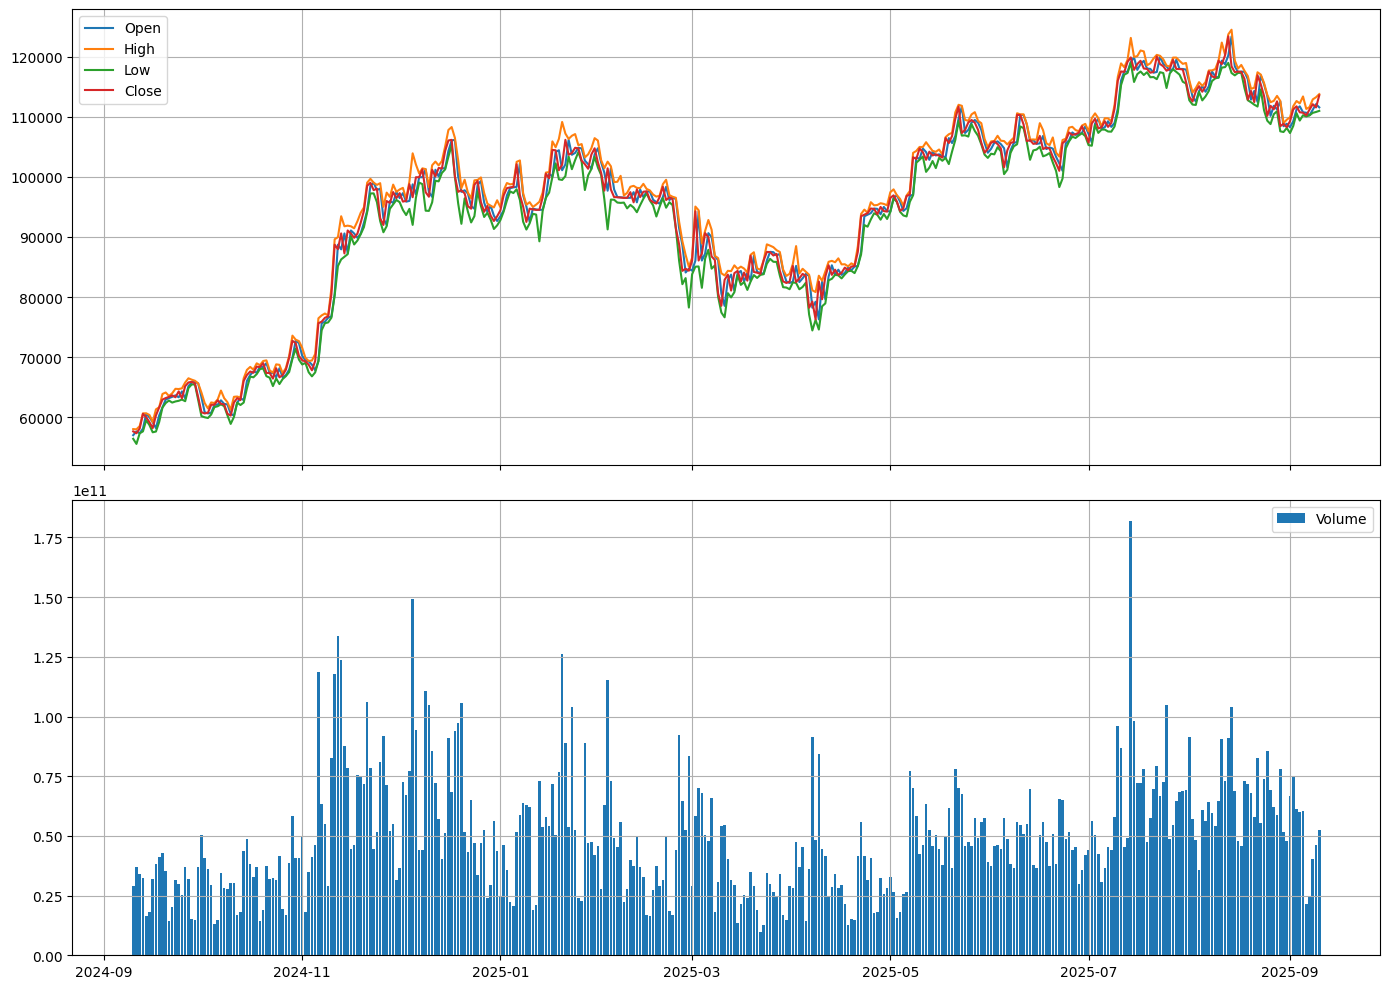

In [8]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

top = ['Open', 'High', 'Low', 'Close']
bottom = ['Volume']

for c in top:
  ax1.plot(ohlc.index, ohlc[c], label=c)

for c in bottom:
  ax2.bar(ohlc.index, ohlc[c], label=c)

for ax in [ax1, ax2]:
  ax.legend()
  ax.grid(True)

plt.tight_layout()
plt.show()

## Moving Averages

In [9]:
def simpleMA( metric, window ):
  return metric.rolling( window ).mean()

def expMA( metric, window ):
  return metric.ewm( span=window, min_periods=window ).mean()

                price     sma(30)        ema(30)
Date                                            
2025-09-06  110224.70  114061.796  112719.860474
2025-09-07  111167.62  113877.759  112619.715928
2025-09-08  112071.43  113730.128  112584.342642
2025-09-09  111530.55  113470.921  112516.356020
2025-09-10  113538.72  113297.830  112582.314986


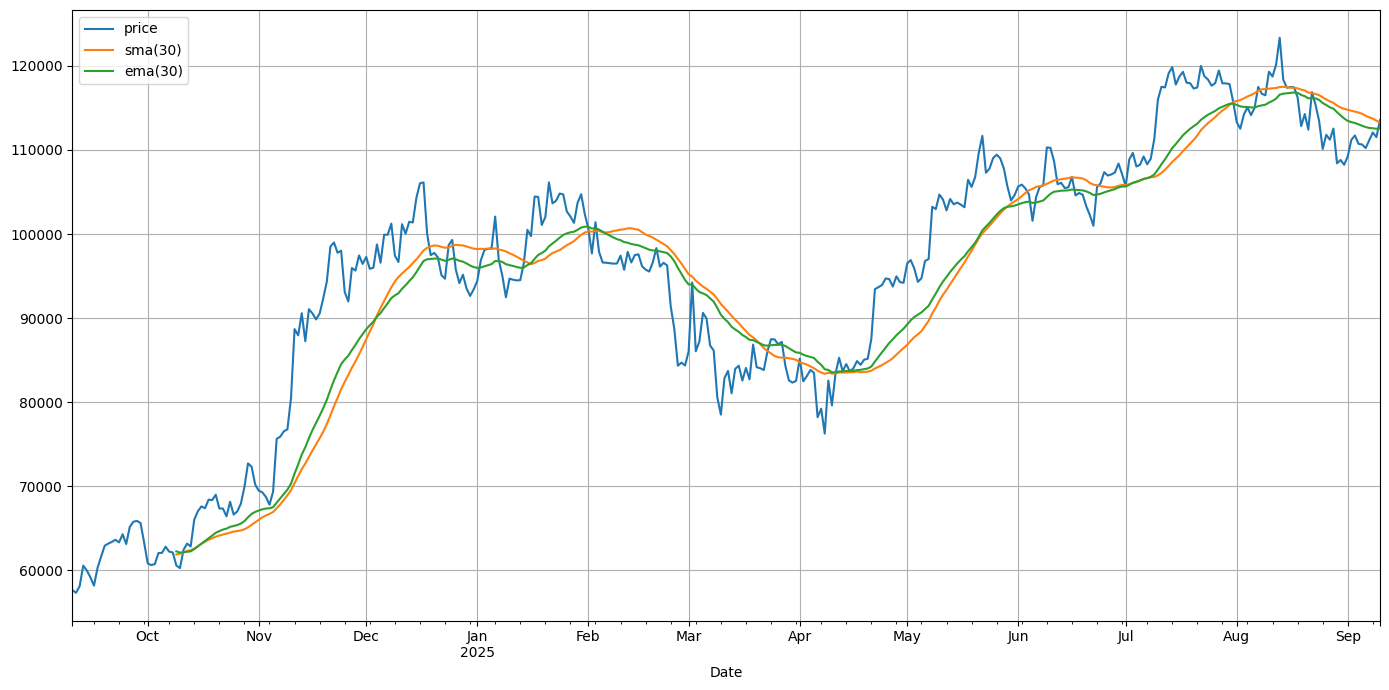

In [10]:
price = ohlc['Close']

window = 30

MA = pd.DataFrame({
    'price': price,
    f'sma({window})': simpleMA(price, window),
    f'ema({window})': expMA(price, window), })

print(MA.tail())

# plot
ax = MA.plot(figsize=(14, 7))
ax.grid(True)
plt.tight_layout()
plt.show()

## Crossover

In [11]:
def crossover( s1, s2, lag ):
  x = s1 - s2
  x = x * 0 + np.sign(x)
  return x.shift(lag)

                price        sma(50)      sma(15)  x(15,50)
Date                                                       
2025-09-06  110224.70  110917.061333  115158.4644      -1.0
2025-09-07  111167.62  110636.614000  115023.0172      -1.0
2025-09-08  112071.43  110544.147333  114918.4300      -1.0
2025-09-09  111530.55  110637.894000  114800.2502      -1.0
2025-09-10  113538.72  110753.631333  114671.1164      -1.0


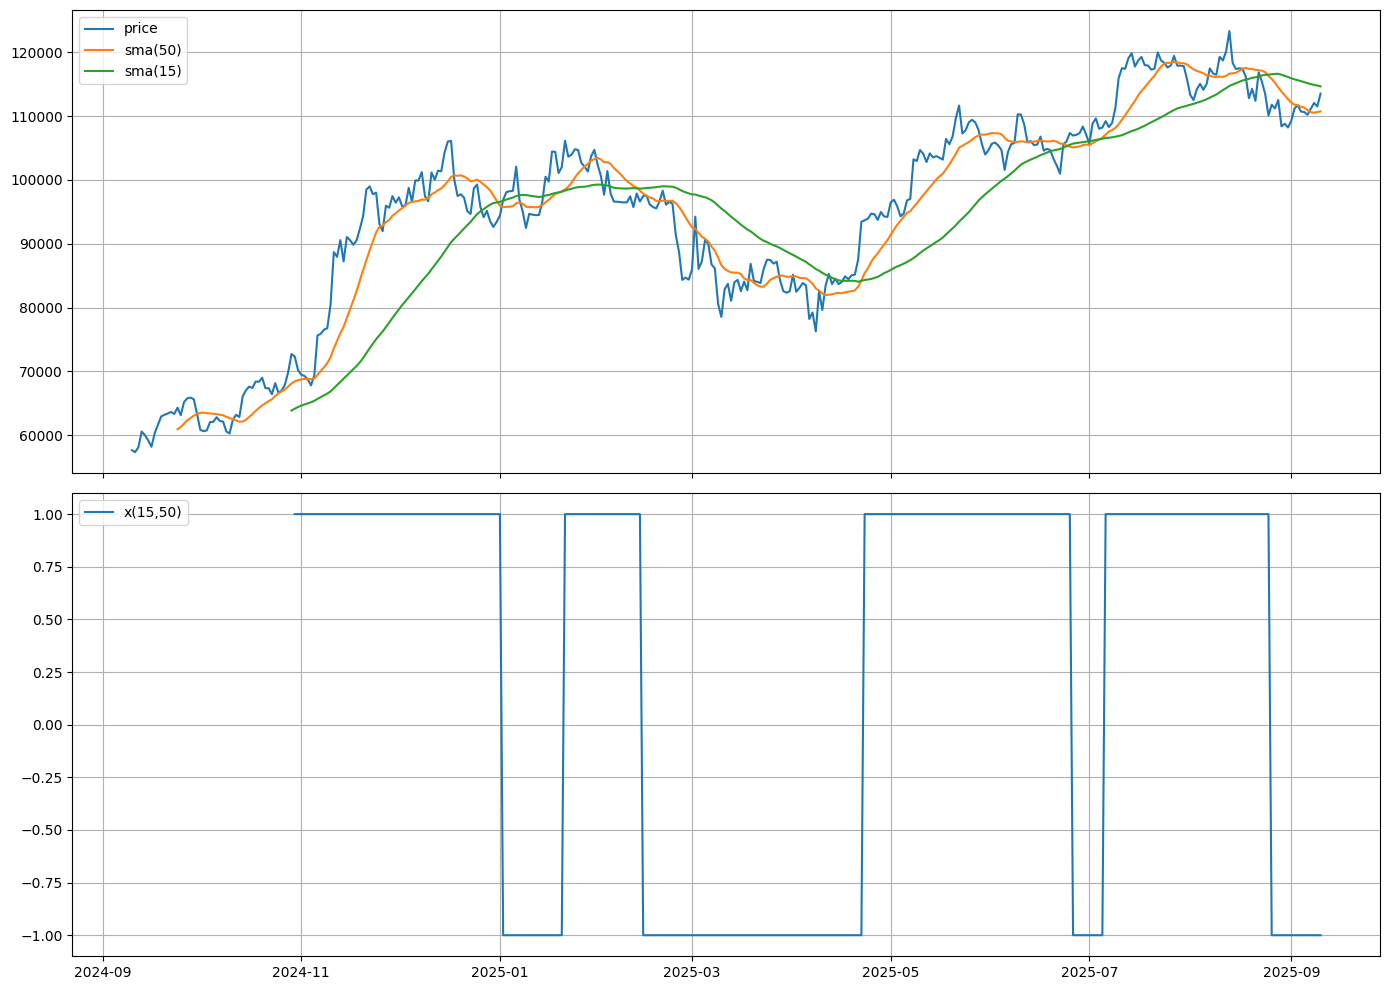

In [12]:
price = ohlc['Close']

short_window = 15
long_window =  50
lag = 1

short = simpleMA(price, short_window)
long  = simpleMA(price, long_window)
cross = crossover(short, long, lag)

Crossover = pd.DataFrame({
    'price': price,
    f'sma({long_window})': short,
    f'sma({short_window})': long,
    f'x({short_window},{long_window})': cross, })

print(Crossover.tail())

# plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

top    = [ c for c in Crossover.columns if not c.startswith('x') ]
bottom = [ c for c in Crossover.columns if c not in top ]

for c in top:
  ax1.plot( Crossover[c], label=c )

for c in bottom:
  ax2.plot( Crossover[c], label=c )

for ax in [ax1, ax2]:
  ax.legend()
  ax.grid(True)

plt.tight_layout()
plt.show()

## Bollinger Bands

In [13]:
def bollUpper( metric, window, stdevs ):
    return boll( metric, window, abs( stdevs ))

def bollLower( metric, window, stdevs ):
    return boll( metric, window, -abs( stdevs ))

def boll( metric, window, stdevs ):
    ma = simpleMA( metric, window )
    std = stDev( metric, window )
    return ma + ( std * stdevs )

def stDev( metric, window ):
    return metric.rolling( window ).std()


                price    upper(20,2)      sma(20)    lower(20,2)
Date                                                            
2025-09-06  110224.70  116790.061701  111820.3635  106850.665299
2025-09-07  111167.62  116080.579405  111566.1290  107051.678595
2025-09-08  112071.43  116010.442618  111528.1415  107045.840382
2025-09-09  111530.55  115683.202514  111390.9320  107098.661486
2025-09-10  113538.72  115824.018564  111446.9165  107069.814436


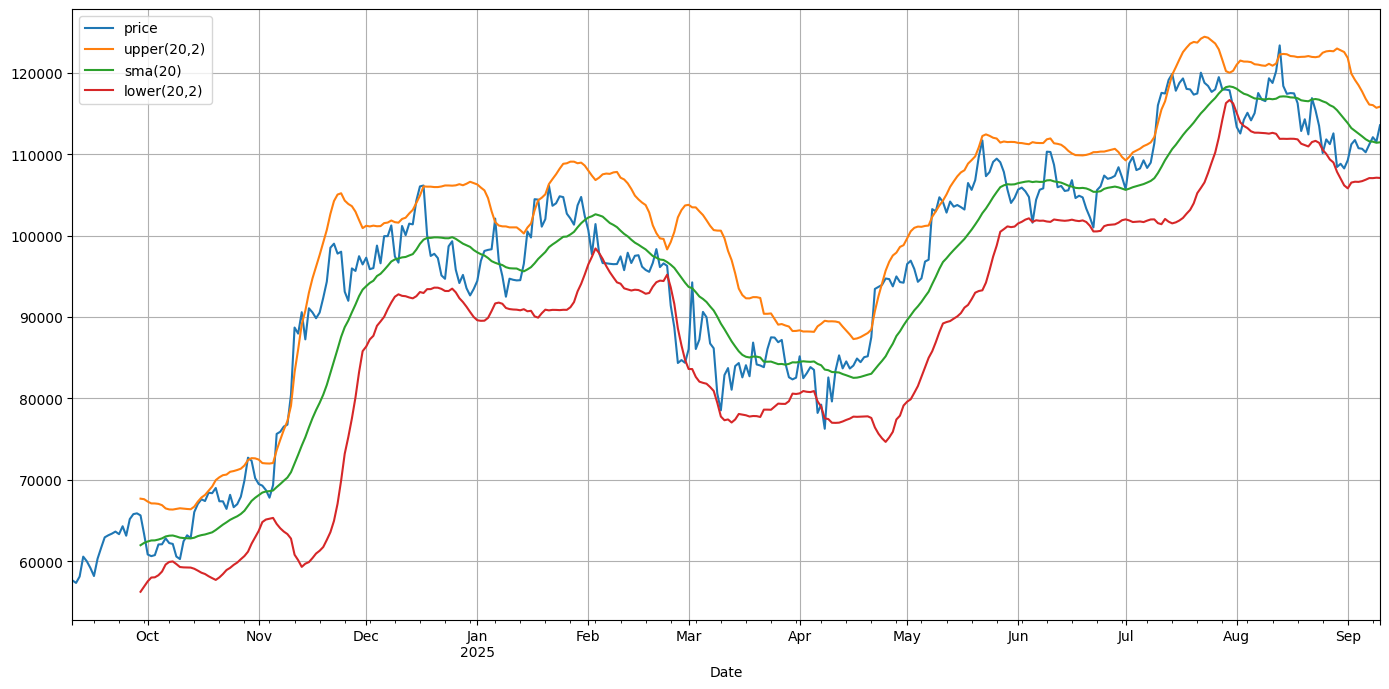

In [14]:
price = ohlc['Close']

window = 20
stdevs = 2

results = [
    price,
    bollUpper(price, window, stdevs),
    simpleMA(price, window),
    bollLower(price, window, stdevs), ]

names = [
    'price',
    f'upper({window},{stdevs})',
    f'sma({window})',
    f'lower({window},{stdevs})', ]

Bollinger = pd.DataFrame(dict(zip(names, results)))

print( Bollinger.tail() )

# plot
ax = Bollinger.plot(figsize=(14, 7))
ax.grid(True)
plt.tight_layout()
plt.show()

### Moving Average Convergence Divergence (MACD)

Moving Average Convergence Divergence (MACD) involves the following three calculations; the last of which, the MACD distance, may be used by analysts in determining the magnitude of bullish or bearish momentum.

1. MACD is the difference between a long and short EMA.

2. The Signal Line is then the EMA of the MACD (#1).

3. The MACD Distance is the difference between the MACD (#1) and Signal Line (#2).

In [15]:
def macd(metric, short_window, long_window):
    short = expMA( metric, short_window )
    long = expMA( metric, long_window )
    return short - long


def macdDistance(macd_metric, signal_metric):
    return macd_metric - signal_metric

In [16]:
price = ohlc['Close']


short_window = 12
long_window = 26
signal_window = 9

short       = expMA( price, short_window )
long        = expMA( price, long_window )
macd_metric = macd( price, short_window, long_window )
signal      = expMA( macd_metric, signal_window )
dist        = macdDistance( macd_metric, signal )

results = [
    price,
    short,
    long,
    macd_metric,
    signal,
    dist, ]

names = [
    'price',
    f'ema({short_window})',
    f'ema({long_window})',
    f'macd({short_window},{long_window})',
    f'signal({signal_window})',
    'distance', ]

Macd = pd.DataFrame(dict(zip(names, results)))

print(Macd.tail())


                price        ema(12)        ema(26)  macd(12,26)    signal(9)  \
Date                                                                            
2025-09-06  110224.70  110987.213173  112454.282811 -1467.069638 -1498.315669   
2025-09-07  111167.62  111014.968069  112358.974454 -1344.006385 -1467.453812   
2025-09-08  112071.43  111177.500674  112337.674865 -1160.174191 -1405.997888   
2025-09-09  111530.55  111231.815955  112277.887838 -1046.071883 -1334.012687   
2025-09-10  113538.72  111586.724270  112371.282813  -784.558543 -1224.121858   

              distance  
Date                    
2025-09-06   31.246031  
2025-09-07  123.447427  
2025-09-08  245.823697  
2025-09-09  287.940804  
2025-09-10  439.563315  


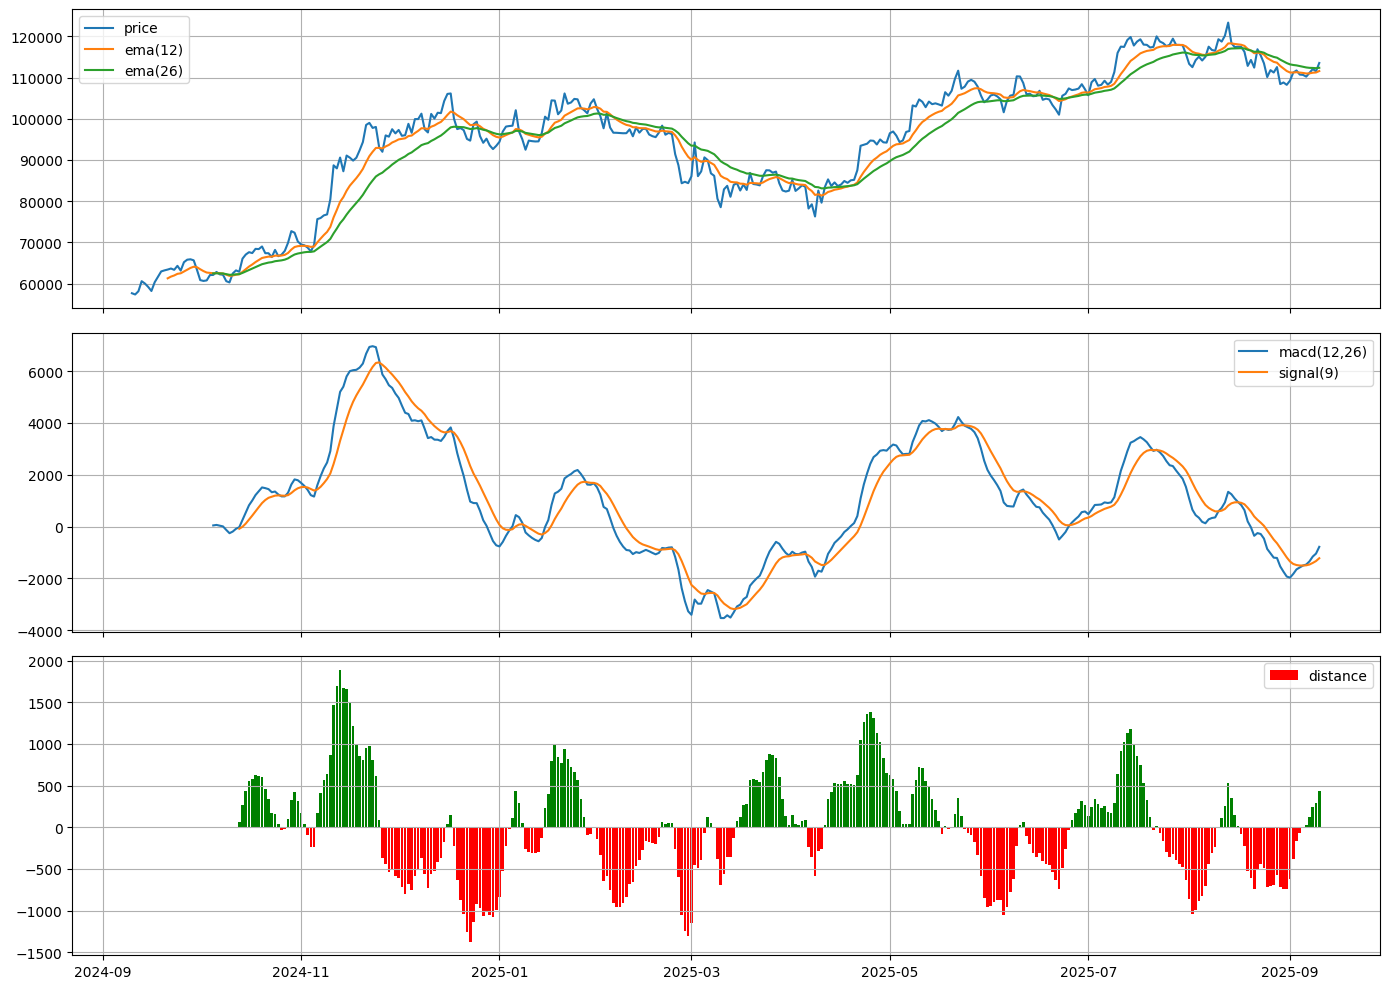

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

top    = [ c for c in Macd.columns if c.startswith(('price', 'ema')) ]
middle = [ c for c in Macd.columns if c.startswith(('macd', 'signal')) ]
bottom = [ 'distance' ]

for c in top:
  ax1.plot( Macd[c], label=c )

for c in middle:
  ax2.plot( Macd[c], label=c )


for c in bottom:
  series = Macd[c]
  colors = ['green' if v > 0 else 'red' for v in series]
  ax3.bar(Macd.index, series, label=c, color=colors)

for ax in [ax1, ax2, ax3]:
  ax.legend()
  ax.grid(True)

plt.tight_layout()
plt.show()